In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.metrics import f1_score, precision_score, recall_score, plot_confusion_matrix, confusion_matrix
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# read in data

train_values = pd.read_csv('data/Proj5_train_values.csv')
train_labels = pd.read_csv('data/Proj5_train_labels.csv')

#### Label Encode

In [3]:
# Label Encode categorical features

le = LabelEncoder()
train_enc = train_values.apply(le.fit_transform)
train_enc

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,198723,6,482,11250,1,6,5,3,2,2,...,0,0,0,0,0,0,0,0,0,0
1,7210,8,891,2602,1,2,7,5,1,2,...,0,0,0,0,0,0,0,0,0,0
2,23774,21,359,8286,1,2,4,3,2,2,...,0,0,0,0,0,0,0,0,0,0
3,146212,22,413,9868,1,2,5,3,2,2,...,0,0,0,0,0,0,0,0,0,0
4,50437,11,129,1371,2,6,7,7,2,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,170650,25,1322,1491,0,11,5,1,0,2,...,0,0,0,0,0,0,0,0,0,0
260597,165884,17,708,1893,1,0,5,3,2,2,...,0,0,0,0,0,0,0,0,0,0
260598,149084,17,50,7546,2,11,5,5,2,2,...,0,0,0,0,0,0,0,0,0,0
260599,37871,26,38,1702,1,2,13,4,2,2,...,0,0,0,0,0,0,0,0,0,0


## Modeling with 10% of data
- For faster processing

In [4]:
# grab first 10% of rows

train_enc_10pct = train_enc.head(int(len(train_values) * 0.1))
train_labels_10pct = train_labels.head(int(len(train_labels) * 0.1))

#### Baseline + TTS

In [25]:
# baseline model

train_labels_10pct['damage_grade'].value_counts(normalize = True)

2    0.567421
3    0.336109
1    0.096470
Name: damage_grade, dtype: float64

In [5]:
# establish X + y

X = train_enc_10pct.drop(columns = ['building_id'])
y = train_labels_10pct['damage_grade']

In [6]:
# tts

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 123)

#### Modeling

In [39]:
# Random Forest

pipe_forest = make_pipeline(StandardScaler(), RandomForestClassifier(n_jobs = -1, random_state = 123))

params = {'randomforestclassifier__max_depth' : [6, 7, 8, 9, 10, 11],
          'randomforestclassifier__max_features' : [15, 20, 30, 35]}

grid_forest = GridSearchCV(pipe_forest, param_grid = params)

grid_forest.fit(X_train, y_train)

print(f'Train Score: {grid_forest.score(X_train, y_train)}')
print(f'Test Score: {grid_forest.score(X_test, y_test)}')

grid_forest.best_params_

Train Score: 0.7793809158352519
Test Score: 0.688871834228703


{'randomforestclassifier__max_depth': 11,
 'randomforestclassifier__max_features': 35}

In [40]:
# grab feature importances -- CONSOLIDATED

forest_fi_df = pd.DataFrame({'importances': grid_forest.best_estimator_.named_steps['randomforestclassifier'].feature_importances_, 
                             'name': X_train.columns}).sort_values('importances', ascending = False)
forest_fi_df[:5]

,importances,name
0,0.344915,geo_level_1_id
1,0.101361,geo_level_2_id
2,0.093450,geo_level_3_id
4,0.080014,age
15,0.058940,has_superstructure_mud_mortar_stone


In [41]:
# extract permutation importances
pimports = permutation_importance(grid_forest.best_estimator_, X_test, y_test, n_repeats = 10, n_jobs = -1)

In [42]:
#sort by averages
sort_idx = pimports.importances_mean.argsort()

In [43]:
#create a Dataframe sorted by importance
imp_df = pd.DataFrame(pimports.importances[sort_idx].T, columns = X_test.columns[sort_idx])

In [96]:
imp_df

,plan_configuration,has_superstructure_bamboo,has_superstructure_other,has_superstructure_timber,has_secondary_use_rental,position,has_secondary_use_other,has_secondary_use_gov_office,has_secondary_use_health_post,has_secondary_use_industry,...,area_percentage,ground_floor_type,other_floor_type,geo_level_3_id,roof_type,foundation_type,age,geo_level_2_id,has_superstructure_mud_mortar_stone,geo_level_1_id
0,-0.000307,-0.000460,-0.000153,0.001535,-0.000153,-0.000307,0.0,0.0,0.0,0.0,...,0.001842,0.002302,0.005679,0.004144,0.004758,0.009517,0.009363,0.015503,0.036071,0.153952
1,-0.000307,-0.000153,0.000000,-0.000921,-0.000153,0.000614,0.0,0.0,0.0,0.0,...,0.001535,0.001381,0.000921,0.002763,0.005372,0.009670,0.008749,0.009363,0.031312,0.146278
2,-0.000921,-0.000153,-0.000307,0.000000,0.000000,0.001842,0.0,0.0,0.0,0.0,...,0.003684,0.001688,0.002609,0.002149,0.005065,0.008749,0.011051,0.014735,0.031773,0.142901
3,-0.000307,-0.000614,-0.000307,-0.000307,-0.000153,-0.001381,0.0,0.0,0.0,0.0,...,0.004298,0.003530,0.004298,0.005679,0.006293,0.008749,0.010437,0.013507,0.030084,0.140599
4,-0.000460,0.000000,0.000307,0.001228,0.000153,0.001535,0.0,0.0,0.0,0.0,...,0.003070,0.003223,0.003530,0.003070,0.004144,0.010437,0.007214,0.013814,0.031466,0.147199
5,-0.000153,0.000000,-0.000307,-0.000921,-0.000153,-0.000767,0.0,0.0,0.0,0.0,...,0.000000,0.001074,0.003070,0.002916,-0.000307,0.009363,0.010898,0.015810,0.032540,0.148273
6,0.000000,-0.000153,0.000000,0.000000,-0.000153,0.000307,0.0,0.0,0.0,0.0,...,0.002916,0.003837,0.001535,0.004298,0.006754,0.007675,0.008903,0.010591,0.034229,0.149348
7,-0.000153,0.000153,-0.000153,-0.001381,-0.000153,-0.000614,0.0,0.0,0.0,0.0,...,0.001688,0.003070,0.003991,0.002763,-0.000153,0.009363,0.007828,0.013047,0.027782,0.149808
8,-0.000614,-0.000307,-0.000153,0.000614,-0.000153,-0.001228,0.0,0.0,0.0,0.0,...,0.003530,0.004912,0.003684,0.004912,0.005065,0.009363,0.012126,0.017959,0.035764,0.142287
9,0.000000,-0.000307,-0.000460,-0.001074,-0.000153,-0.000460,0.0,0.0,0.0,0.0,...,0.005372,0.003684,0.001535,0.003837,0.007061,0.006907,0.007982,0.011972,0.030238,0.142901


<AxesSubplot:>

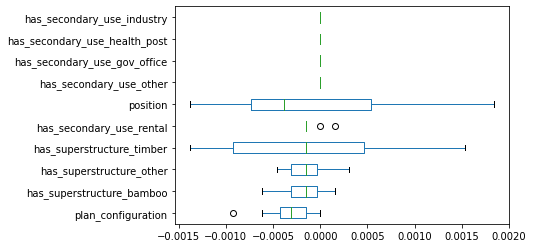

In [88]:
#draw a boxplot -- first 10 features

imp_df.iloc[:, :10].plot(kind = 'box', vert = False)

<AxesSubplot:>

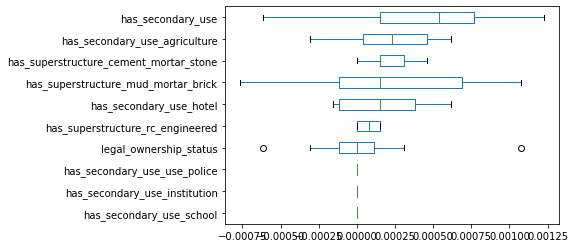

In [90]:
# next 10 features

imp_df.iloc[:, 10:20].plot(kind = 'box', vert = False)

<AxesSubplot:>

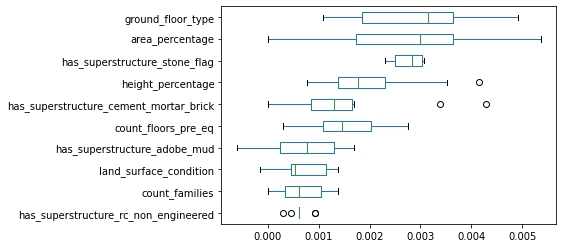

In [91]:
# next 10 features

imp_df.iloc[:, 20:30].plot(kind = 'box', vert = False)

<AxesSubplot:>

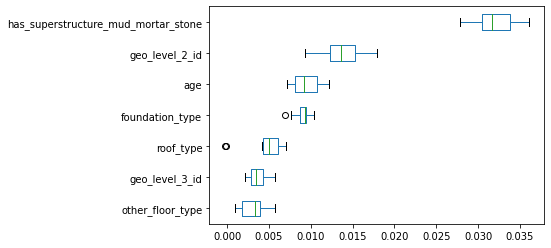

In [98]:
# last 8 features

imp_df.iloc[:, 30:-1].plot(kind = 'box', vert = False)

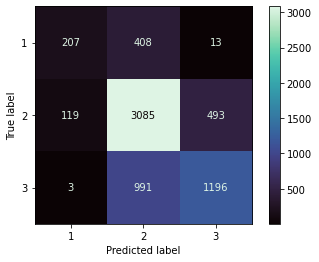

In [58]:
# confusion matrix
plot_confusion_matrix(grid_forest, X_test, y_test, cmap = 'mako');

- True Positives: 
    - Damage Grade 1: 207
    - Damage Grade 2: 3,085
    - Damage Grade 3: 1,196

In [53]:
# Extra Trees

pipe_trees = make_pipeline(StandardScaler(), ExtraTreesClassifier(n_jobs = -1, random_state = 123))

params = {'extratreesclassifier__max_depth' : [6, 7, 8, 9, 10, 11],
          'extratreesclassifier__max_features' : [15, 20, 30, 35]}

grid_trees = GridSearchCV(pipe_trees, param_grid = params)

grid_trees.fit(X_train, y_train)

print(f'Train Score: {grid_trees.score(X_train, y_train)}')
print(f'Test Score: {grid_trees.score(X_test, y_test)}')

grid_trees.best_params_

Train Score: 0.7532872857508314
Test Score: 0.6785878741366078


{'extratreesclassifier__max_depth': 11,
 'extratreesclassifier__max_features': 35}

In [54]:
# grab feature importances -- CONSOLIDATED

trees_fi_df = pd.DataFrame({'importances': grid_trees.best_estimator_.named_steps['extratreesclassifier'].feature_importances_, 
                             'name': X_train.columns}).sort_values('importances', ascending = False)
trees_fi_df[:5]

,importances,name
0,0.399236,geo_level_1_id
15,0.103072,has_superstructure_mud_mortar_stone
14,0.049716,has_superstructure_adobe_mud
18,0.034467,has_superstructure_mud_mortar_brick
1,0.033432,geo_level_2_id


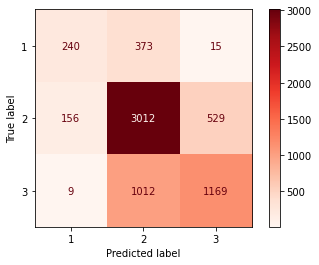

In [55]:
# confusion matrix
plot_confusion_matrix(grid_trees, X_test, y_test, cmap = 'Reds');

- True Positives: 
    - Damage Grade 1: 240
    - Damage Grade 2: 3,085
    - Damage Grade 3: 1,196

## EDA / Data Viz

In [21]:
earthquake = pd.merge(train_values.head(int(len(train_values) * 0.1)), train_labels.head(int(len(train_labels) * 0.1)), on = 'building_id')
earthquake

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26055,15224,20,1161,1436,2,10,8,5,t,r,...,0,0,0,0,0,0,0,0,0,2
26056,239671,10,1407,11907,3,65,6,7,t,r,...,0,0,0,0,0,0,0,0,0,3
26057,977262,17,233,9990,3,25,8,7,t,r,...,0,0,0,0,0,0,0,0,0,3
26058,906011,21,46,5919,2,10,8,5,t,r,...,0,0,0,0,0,0,0,0,0,2


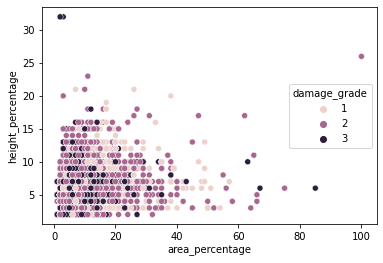

In [22]:
sns.scatterplot(x = 'area_percentage', y = 'height_percentage', data = earthquake, hue = 'damage_grade');

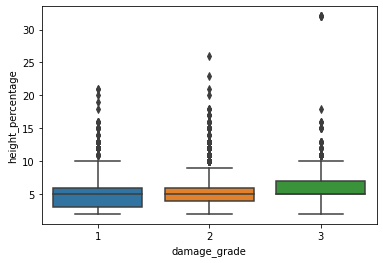

In [23]:
sns.boxplot(x = 'damage_grade', y = 'height_percentage', data = earthquake);

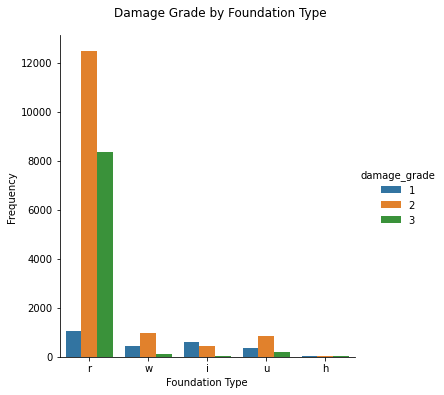

In [28]:
# referenced https://seaborn.pydata.org/generated/seaborn.catplot.html

sns.catplot(x = "foundation_type", data = earthquake, kind = "count", hue = 'damage_grade').set(xlabel = 'Foundation Type', ylabel = 'Frequency');
plt.suptitle('Damage Grade by Foundation Type', y = 1.05);

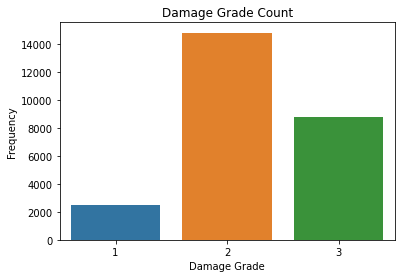

In [35]:
# referenced https://seaborn.pydata.org/generated/seaborn.catplot.html

sns.countplot(x = "damage_grade", data = earthquake)
plt.xlabel('Damage Grade')
plt.ylabel('Frequency')
plt.title('Damage Grade Count');

In [13]:
train_values['age'].max()

995